In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import defaultdict
from tensorflow.keras.layers import *
import tensorflow.keras as keras
from keras.initializers import RandomNormal
from tensorflow.keras import *
from keras.utils import np_utils
import sklearn

Using TensorFlow backend.


In [0]:
def read_data(train_path,ho_path):
    train_data = pd.read_csv(train_path)

    ho_data = pd.read_csv(ho_path)
    ho_data.loc[:, 'userID'] = ho_data.apply(lambda x: x['userID-bookID'].split('-')[0], axis=1)
    ho_data.loc[:, 'bookID'] = ho_data.apply(lambda x: x['userID-bookID'].split('-')[1], axis=1)

    return train_data, ho_data


In [0]:

def extract_mappings(data,ratings_available=True):

    book_to_user = defaultdict(list)
    user_to_book = defaultdict(list)
    ub_rating = defaultdict(dict)
    book_mean_rating = defaultdict(int)
    user_mean_rating = defaultdict(int)
    def update_dict(x):
        book_to_user[x['bid']].append(x['uid'])
        user_to_book[x['uid']].append(x['bid'])
        if ratings_available:
            ub_rating[x['uid']][x['bid']] = x['rating']

    data.apply(lambda x: update_dict(x), axis=1);


    if ratings_available:

        for book in book_to_user.keys():
            ratings = []
            for user in book_to_user[book]:
                ratings.append(ub_rating[user][book])
            book_mean_rating[book] = np.nanmean(ratings)

        for user in user_to_book.keys():
            ratings = []
            for book in user_to_book[user]:
                ratings.append(ub_rating[user][book])
            user_mean_rating[user] = np.nanmean(ratings)

        return book_to_user, user_to_book, ub_rating, book_mean_rating, user_mean_rating
    else: return book_to_user, user_to_book


In [0]:
def split_data(data,ratios=[0.70,0.15,0.15],seed=1000):

    n = len(data)
    #np.random.seed(seed)
    #data = data.copy().sample(frac=1).reset_index(drop=True)
    train = data[:int(n*ratios[0])]
    val = data[int(n*ratios[0]):int(n*(ratios[0]+ratios[1]))]
    test = data[int(n*(ratios[0]+ratios[1])):]
    return train, val, test


In [0]:
train_data, ho_data = read_data(train_path='train_Interactions.csv',ho_path='pairs_Read.txt')
rating_data = pd.read_csv('pairs_Rating.txt')


In [0]:
rating_data.loc[:, 'userID'] = rating_data.apply(lambda x: x['userID-bookID'].split('-')[0], axis=1)
rating_data.loc[:, 'bookID'] = rating_data.apply(lambda x: x['userID-bookID'].split('-')[1], axis=1)
rating_data.loc[:,'rating'] = rating_data.apply(lambda x: -1)
rating_data = rating_data.drop(columns=['prediction'])
rating_data = rating_data.drop(columns=['userID-bookID'])

In [0]:
# Do mapping to integers
uid_to_index = {}
bid_to_index = {}
index_to_uid = {}
index_to_bid = {}

users = np.unique(train_data.userID)
books = np.unique(train_data.bookID)
    
for index,user in enumerate(users):
    uid_to_index[user] = index
    index_to_uid[index] = user
for index,book in enumerate(books):
    bid_to_index[book] = index
    index_to_bid[index] = book
    
train_data.loc[:,'uid'] = train_data.apply(lambda x: uid_to_index[x['userID']],axis=1)    
train_data.loc[:,'bid'] = train_data.apply(lambda x: bid_to_index[x['bookID']],axis=1)   
ho_data.loc[:,'uid'] = ho_data.apply(lambda x: uid_to_index[x['userID']],axis=1)   
ho_data.loc[:,'bid'] = ho_data.apply(lambda x: bid_to_index[x['bookID']],axis=1)   
rating_data.loc[:,'uid'] = rating_data.apply(lambda x: uid_to_index[x['userID']],axis=1)   
rating_data.loc[:,'bid'] = rating_data.apply(lambda x: bid_to_index[x['bookID']],axis=1)   

In [0]:
train, val, test = split_data(train_data,ratios=[0.90,0.05,0.05],seed=111)

In [0]:
train = train.append(rating_data)

In [0]:
len(train), len(val), len(test)

(190000, 10000, 10000)

## Negative Sampling

In [0]:
overall_book_to_user, overall_user_to_book, overall_ub_rating, overall_book_mean_rating, overall_user_mean_rating = extract_mappings(train_data)
train_book_to_user, train_user_to_book, train_ub_rating, train_book_mean_rating, train_user_mean_rating = extract_mappings(train)
val_book_to_user, val_user_to_book, val_ub_rating, val_book_mean_rating, val_user_mean_rating = extract_mappings(val)

In [0]:
all_books = set(list(range(len(books))))

train_mapper = {}

for user in range(len(users)):
  train_mapper[user] = {'observed':[],'unobserved':[]}
  
  observed = set(train_user_to_book[user])
  unobserved = all_books.difference(observed)
  train_mapper[user]['observed'] = list(observed)
  train_mapper[user]['unobserved'] = list(unobserved)

#save_dict(train_mapper,'train_mappings.pkl')

val_mapper = {}

for user in range(len(users)):
  val_mapper[user] = {'observed':[],'unobserved':[]}
  
  observed = set(val_user_to_book[user])
  unobserved = all_books.difference(set(overall_user_to_book[user]))
  val_mapper[user]['observed'] = list(observed)
  val_mapper[user]['unobserved'] = list(unobserved)

#save_dict(val_mapper,'val_mappings.pkl')


In [0]:
# Negative Sampling For Validation Set 

np.random.seed(1002)
val.loc[:,'did_read'] = val.apply(lambda x: 1,axis=1)
l = len(val)
for i in range(l):
  uid, bid,userID,bookID,rating = val.iloc[i].uid,val.iloc[i].bid,val.iloc[i].userID,val.iloc[i].bookID,val.iloc[i].rating
  negative = np.random.randint(0,len(books))
  while negative in overall_user_to_book[uid]:
    negative = np.random.randint(0,len(books))
  val = val.append({'userID':userID,'bookID':bookID,'rating':rating,'uid':uid,'bid':negative,'did_read':0},ignore_index=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [0]:
# Negative Sampling For Test Set 

np.random.seed(1002)
test.loc[:,'did_read'] = test.apply(lambda x: 1,axis=1)
l = len(test)
for i in range(l):
  uid, bid,userID,bookID,rating = test.iloc[i].uid,test.iloc[i].bid,test.iloc[i].userID,test.iloc[i].bookID,test.iloc[i].rating
  negative = np.random.randint(0,len(books))
  while negative in overall_user_to_book[uid]:
    negative = np.random.randint(0,len(books))
  test = test.append({'userID':userID,'bookID':bookID,'rating':rating,'uid':uid,'bid':negative,'did_read':0},ignore_index=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [0]:
print('Train: %d, Val: %d, Test: %d'%(len(train),len(val),len(test)))

Train: 190000, Val: 20000, Test: 20000


# Baselines - HW3

### Popular Books Method - Varying Threshold

In [0]:
def get_popular_books(data, r = 0.50):
  stats = pd.DataFrame(data.pivot_table(index='bid',values='rating',aggfunc='count').to_records())
  stats = stats.sort_values(by='rating',ascending=False)
  n = len(stats)
  #print(stats.head())
  popular_books = [0] * len(data)
  total_sum = 0
  popularity_dict_1 = {}
  popularity_dict_2 = {}
  for i in range(len(stats)):
    popular_books[total_sum:(total_sum + stats.iloc[i].rating)] = [stats.iloc[i].bid]*stats.iloc[i].rating
    popularity_dict_1[stats.iloc[i].bid] = stats.iloc[i].rating / len(data)
    popularity_dict_2[stats.iloc[i].bid] = 1.0 - (total_sum/len(data))
    total_sum += stats.iloc[i].rating
  return popular_books,popularity_dict_1,popularity_dict_2

def get_active_users(data, r = 0.50):
  stats = pd.DataFrame(data.pivot_table(index='uid',values='rating',aggfunc='count').to_records())
  stats = stats.sort_values(by='rating',ascending=False)
  n = len(stats)
  #print(stats.head())
  active_users = [0] * len(data)
  total_sum = 0
  activity_dict_1 = {}
  activity_dict_2 = {}
  
  for i in range(len(stats)):
    active_users[total_sum:(total_sum + stats.iloc[i].rating)] = [stats.iloc[i].uid]*stats.iloc[i].rating
    activity_dict_1[stats.iloc[i].uid] = stats.iloc[i].rating / len(data)#1.0 - (total_sum/len(data))
    activity_dict_2[stats.iloc[i].uid] = 1.0 - (total_sum/len(data))
    total_sum += stats.iloc[i].rating
  #print(active_users)
  return active_users,activity_dict_1,activity_dict_2


Baseline popularity-based accuracy with 50th percentile: 0.649400


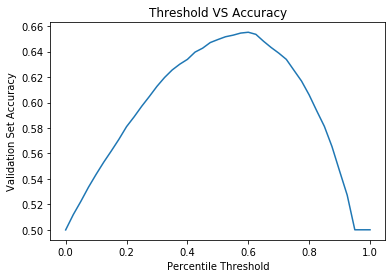

In [0]:
thresholds = np.linspace(0,1,41)
acc = []
books_arr, _, _ = get_popular_books(train, 0)
  
popular_books = np.unique(books_arr[:int(0.50*len(books_arr))])
val.loc[:,'read_prediction_popularity'] = val.apply(lambda x: 1 if x['bid'] in popular_books else 0,axis=1)
baseline_accuracy = np.mean(val.read_prediction_popularity == val.did_read)
print('Baseline popularity-based accuracy with 50th percentile: %f'%baseline_accuracy)


for threshold in thresholds:
  
  popular_books = np.unique(books_arr[:int(threshold*len(books_arr))])
  val.loc[:,'read_prediction_popularity'] = val.apply(lambda x: 1 if x['bid'] in popular_books else 0,axis=1)
  acc.append(np.mean(val.read_prediction_popularity == val.did_read))

plt.figure()
plt.plot(thresholds,acc)
plt.xlabel('Percentile Threshold')
plt.ylabel('Validation Set Accuracy')
plt.title('Threshold VS Accuracy')
plt.show()

[    2    12    29 ... 11348 11349 11354]
Baseline activity-based accuracy with 50th percentile: 0.500000


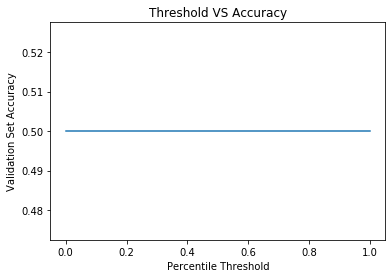

In [0]:
thresholds = np.linspace(0,1,41)
acc = []
users_arr, _, _ = get_active_users(train, 0)
  
active_users = np.unique(users_arr[:int(0.50*len(users_arr))])
print(active_users)
val.loc[:,'read_prediction_activity'] = val.apply(lambda x: 1 if x['uid'] in active_users else 0,axis=1)
baseline_accuracy = np.mean(val.read_prediction_activity == val.did_read)
print('Baseline activity-based accuracy with 50th percentile: %f'%baseline_accuracy)


for threshold in thresholds:
  
  active_users = np.unique(users_arr[:int(threshold*len(users_arr))])
  val.loc[:,'read_prediction_activity'] = val.apply(lambda x: 1 if x['uid'] in active_users else 0,axis=1)
  acc.append(np.mean(val.read_prediction_activity == val.did_read))

plt.figure()
plt.plot(thresholds,acc)
plt.xlabel('Percentile Threshold')
plt.ylabel('Validation Set Accuracy')
plt.title('Threshold VS Accuracy')
plt.show()

In [0]:
_,pop_dict_1,pop_dict_2 = get_popular_books(train, 0)
_,act_dict_1,act_dict_2 = get_active_users(train,0)

val.loc[:,'activity_1'] = val.apply(lambda x: act_dict_1[x['uid']] if x['uid'] in act_dict_1.keys() else 0,axis=1)
val.loc[:,'activity_2'] = val.apply(lambda x: act_dict_2[x['uid']] if x['uid'] in act_dict_2.keys() else 0,axis=1)
val.loc[:,'popularity_1'] = val.apply(lambda x: pop_dict_1[x['bid']] if x['bid'] in pop_dict_1.keys() else 0,axis=1)
val.loc[:,'popularity_2'] = val.apply(lambda x: pop_dict_2[x['bid']] if x['bid'] in pop_dict_2.keys() else 0,axis=1)

if len(test) != 0:
  test.loc[:,'activity_1'] = test.apply(lambda x: act_dict_1[x['uid']] if x['uid'] in act_dict_1.keys() else 0,axis=1)
  test.loc[:,'activity_2'] = test.apply(lambda x: act_dict_2[x['uid']] if x['uid'] in act_dict_2.keys() else 0,axis=1)
  test.loc[:,'popularity_1'] = test.apply(lambda x: pop_dict_1[x['bid']] if x['bid'] in pop_dict_1.keys() else 0,axis=1)
  test.loc[:,'popularity_2'] = test.apply(lambda x: pop_dict_2[x['bid']] if x['bid'] in pop_dict_2.keys() else 0,axis=1)


### Max Similarity Based - Varying Threshold

In [0]:
def calculate_similarity_book(b1,b2,mode='jacard'):
  if mode == 'jacard':
    return len(np.intersect1d(book_to_user[b1], book_to_user[b2])) / len(
            np.union1d(book_to_user[b1], book_to_user[b2]))
  elif mode == 'cross_corr':
    common_users = np.intersect1d(book_to_user[b1],book_to_user[b2])
    r1 = []
    r2 = []
    for user in common_users:
      r1.append(ub_rating[user][b1])
      r2.append(ub_rating[user][b2])
    #print(r1,r2,len(np.intersect1d(book_to_user[b1], book_to_user[b2])) / len(
            #np.union1d(book_to_user[b1], book_to_user[b2])))
    #return np.corrcoef(r1,r2)[0][1]
    #print(r1,r2)
    return np.dot(r1,r2)
  

def get_max_similarity_book(uid,bid,mode='jacard'):
  max_similarity = 0.0
  sims = []
  for book in user_to_book[uid]: 
    similarity = calculate_similarity_book(book,bid,mode=mode)
    #print(similarity)
    if not np.isnan(similarity):
      max_similarity = max(max_similarity,similarity)
      sims.append(similarity)

  sims.sort()
  if min(len(sims),m) == 0:
    return max_similarity
  return np.mean(sims[- min(len(sims),m):])

def calculate_similarity_user(u1,u2,mode='jacard'):
  if mode == 'jacard':
    return len(np.intersect1d(user_to_book[u1], user_to_book[u2])) / len(
            np.union1d(user_to_book[u1], user_to_book[u2]))
  elif mode == 'cross_corr':
    common_books = np.intersect1d(user_to_book[u1],user_to_book[u2])
    r1 = []
    r2 = []
    for book in common_books:
      r1.append(ub_rating[u1][book])
      r2.append(ub_rating[u2][book])
    #return np.corrcoef(r1,r2)[0][0]
    return np.dot(r1,r2)

def get_max_similarity_user(uid,bid,mode='jacard'):
  max_similarity = 0.0
  sims = []
  for user in book_to_user[bid]: 
    similarity = calculate_similarity_user(user,uid,mode=mode)
    
    if not np.isnan(similarity):
      max_similarity = max(max_similarity,similarity)
      sims.append(similarity)

  sims.sort()
  if min(len(sims),m) == 0:
    return max_similarity
  return np.mean(sims[- min(len(sims),m):])



In [0]:

book_to_user, user_to_book, ub_rating, book_mean_rating, user_mean_rating = extract_mappings(train)

for m in [1,3,5,7]:
  # Run for different values of m and see which works best
  print('M = %d'%m)
  
  val.loc[:,'max_similarity_book_'+str(m)] = val.apply(lambda x: get_max_similarity_book(x['uid'],x['bid'],'jacard'),axis=1)
  val.loc[:,'max_similarity_user_'+str(m)] = val.apply(lambda x: get_max_similarity_user(x['uid'],x['bid'],'jacard'),axis=1)
  
  if len(test) != 0:
    test.loc[:,'max_similarity_book_'+str(m)] = test.apply(lambda x: get_max_similarity_book(x['uid'],x['bid'],'jacard'),axis=1)
    test.loc[:,'max_similarity_user_'+str(m)] = test.apply(lambda x: get_max_similarity_user(x['uid'],x['bid'],'jacard'),axis=1)
  
  #print('Max Similarity Average Values: ',np.mean(val.max_similarity_book), np.mean(val.max_similarity_user))

  # thresholds = np.linspace(0,1,100)
  # acc = []
  # for threshold in thresholds:
  #   val.loc[:,'read_prediction_jc'] = val.apply(lambda x: 1 if x['max_similarity_book_'+str(m)] >= threshold else 0,axis=1)
  #   acc.append(np.mean(val.read_prediction_jc == val.did_read))

  # plt.figure()
  # plt.plot(thresholds,acc)
  # plt.xlabel('Max Similarity Threshold')
  # plt.ylabel('Validation Set Accuracy')
  # plt.title('Threshold VS Accuracy')
  # plt.show()

  # index = np.argmax(acc)
  # print('Best jacard based (threshold,accuracy): (%f,%f)'%(thresholds[index],acc[index]))


  # thresholds = np.linspace(0,1,100)
  # acc = []
  # for threshold in thresholds:
  #   val.loc[:,'read_prediction_jc'] = val.apply(lambda x: 1 if x['max_similarity_user_'+str(m)] >= threshold else 0,axis=1)
  #   acc.append(np.mean(val.read_prediction_jc == val.did_read))

  # plt.figure()
  # plt.plot(thresholds,acc)
  # plt.xlabel('Max Similarity Threshold')
  # plt.ylabel('Validation Set Accuracy')
  # plt.title('Threshold VS Accuracy')
  # plt.show()

  # index = np.argmax(acc)
  # print('Best jacard based (threshold,accuracy): (%f,%f)'%(thresholds[index],acc[index]))


M = 1
M = 3
M = 5
M = 7


### Ranking Method - Training

In [0]:
import pickle
def save_dict(d,filename):
  f = open(filename,"wb")
  pickle.dump(d,f)
  f.close()

def load_dict(filename):
  f = open(filename,'rb')
  d = pickle.load(f)
  return d

In [0]:
def create_datasets(train,val,batch_size=3):
  tf_train = tf.data.Dataset.from_tensor_slices((train.uid,train.bid)).shuffle(buffer_size=1000).batch(batch_size)
  tf_val = tf.data.Dataset.from_tensor_slices((val.uid,val.bid)).batch(batch_size)
  tf_eval = tf.data.Dataset.from_tensor_slices((train.uid,train.bid)).shuffle(buffer_size=1000).batch(batch_size)
  iterator = tf.data.Iterator.from_structure(tf_train.output_types,
                                                tf_train.output_shapes)
  eval_iterator = tf.data.Iterator.from_structure(tf_eval.output_types,
                                                tf_eval.output_shapes)
  train_init_op = iterator.make_initializer(tf_train)
  val_init_op = iterator.make_initializer(tf_val)
  eval_init_op = eval_iterator.make_initializer(tf_eval)

  next_element = iterator.get_next()
  next_element_eval = eval_iterator.get_next()

  return train_init_op, val_init_op, eval_init_op, next_element, next_element_eval


In [0]:
n = len(users)
m = len(books)
K = 6
print(n,m,K)

11357 7170 6


In [0]:
len(train)

190000

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding

tf.reset_default_graph()
train_init_op, val_init_op, eval_init_op, next_element, next_element_eval = create_datasets(train,val,batch_size=10000)

In [0]:
user_embedding = Embedding(n,K)
book_embedding = Embedding(m,K)
user_bias_embedding = Embedding(n,1)
book_bias_embedding = Embedding(m,1)

uid_ph = tf.placeholder(dtype=tf.int32,shape=(None,1))
bid1_ph = tf.placeholder(dtype=tf.int32,shape=(None,1))
bid2_ph = tf.placeholder(dtype=tf.int32,shape=(None,1))

score_1 = user_bias_embedding(uid_ph) + book_bias_embedding(bid1_ph)
score_1 = score_1 + Dot(axes=2)([user_embedding(uid_ph),book_embedding(bid1_ph)])
score_2 = Add()([user_bias_embedding(uid_ph),book_bias_embedding(bid2_ph)])
score_2 = score_2 + Dot(axes=2)([user_embedding(uid_ph),book_embedding(bid2_ph)])

weight_decay = 0.0001
reg_losses = tf.reduce_mean(tf.math.pow(user_embedding.weights,2)) +  tf.reduce_mean(tf.math.pow(book_embedding.weights,2)) +  tf.reduce_mean(tf.math.pow(user_bias_embedding.weights,2)) + tf.reduce_mean(tf.math.pow(book_bias_embedding.weights,2))
reg_losses = weight_decay * reg_losses


gain = tf.math.sigmoid(score_1 - score_2)
mean_gain = tf.reduce_mean(gain)
optimizer = tf.train.AdamOptimizer(0.001).minimize(-mean_gain+reg_losses)

performance_check_sample_size = 1000
n_train = len(train)
n_val = len(val)
n_epochs = 200


In [0]:

saver = tf.train.Saver()
load_path = None
load_path = './model__checkpoint_' + str(39) + '.ckpt'

with tf.device('/gpu:0'):
  with tf.Session() as sess:
    np.random.seed(1002)
    sess.run(tf.global_variables_initializer())

    if load_path is not None:
      saver.restore(sess,load_path)

    n_samples = 20
    for epoch in range(n_epochs):
      sess.run(train_init_op)
      for _ in range(n_train//10000):
        # uid,bid1 = sess.run(next_element)
        # for s in range(n_samples):
        #   bid2 = train_mapper[uid]['unobserved'][np.random.randint(len(train_mapper[uid]['unobserved']))]
        batch_data = sess.run(next_element)
        uid_data = np.expand_dims(batch_data[0],axis=1)
        bid1_data = np.expand_dims(batch_data[1],axis=1)
        bid2_data = np.expand_dims(batch_data[1],axis=1).copy()
        
        for s in range(n_samples):
          for index,uid_data_ in enumerate(uid_data):        
              bid2_data[index][0] = train_mapper[uid_data_[0]]['unobserved'][np.random.randint(len(train_mapper[uid_data_[0]]['unobserved']))]
            #_, likelihood = sess.run([optimizer,gain],feed_dict={uid_ph:(uid,), bid1_ph:(bid1,), bid2_ph:(bid2,)})
          _, likelihood = sess.run([optimizer,gain],feed_dict={uid_ph:uid_data, bid1_ph:bid1_data, bid2_ph:bid2_data})
       
              
      if (epoch+1) % 20 == 0:
        predictions = []
        predictions_2 = []
        for i in range(len(val)):
          uid = val.iloc[i].uid
          bid = val.iloc[i].bid
          books_read_by_user = np.expand_dims(np.array(train_user_to_book[uid]),1)
          uid = np.expand_dims(np.array([uid] * len(books_read_by_user)),1)
          bid = np.expand_dims(np.array([bid] * len(books_read_by_user)),1)
          prefs, curr = sess.run([score_1,score_2],feed_dict={uid_ph:(uid),bid1_ph:(books_read_by_user),bid2_ph:(bid)})
          prefs = np.min(prefs)
          curr = np.mean(curr)
          if curr < prefs:
            predictions.append(0)
          else: predictions.append(1)

          if (prefs > 0 and curr / prefs < 0.50) or (prefs < 0 and curr < prefs):
            predictions_2.append(0)
          else: predictions_2.append(1)
      
        print('Epoch: %d, Accuracy: %f, %f'%(epoch,np.mean(predictions==val.did_read),np.mean(predictions_2==val.did_read)))
        if (epoch+1) % 20 == 0:
          saver.save(sess,'./models6e/model__checkpoint_' + str(epoch) + '.ckpt')
      


INFO:tensorflow:Restoring parameters from ./model__checkpoint_39.ckpt
Epoch: 19, Accuracy: 0.706150, 0.711800
Epoch: 39, Accuracy: 0.704650, 0.711400
Epoch: 59, Accuracy: 0.706450, 0.711250
Epoch: 79, Accuracy: 0.705000, 0.711200
Epoch: 99, Accuracy: 0.707000, 0.711450
Epoch: 119, Accuracy: 0.704850, 0.709950


### Ranking Method - Evaluation

In [0]:
load_path = './model__checkpoint_' + str(39) + '.ckpt'

def get_predictions(data,load_path = load_path):
  saver = tf.train.Saver()

  with tf.device('/gpu:0'):
    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())

      if load_path is not None:
        saver.restore(sess,load_path)

      prefs_arr = []
      curr_arr = []
      predictions = []
      predictions_2 = []
      scores_arr = []
      solution = defaultdict(list)
      scores_dict = defaultdict(dict)
      
      for i in range(len(data)):
        uid = data.iloc[i].uid
        bid = data.iloc[i].bid
        books_read_by_user = np.expand_dims(np.array(train_user_to_book[uid]),1)
        uid = np.expand_dims(np.array([uid] * len(books_read_by_user)),1)
        bid = np.expand_dims(np.array([bid] * len(books_read_by_user)),1)
        prefs, curr = sess.run([score_1,score_2],feed_dict={uid_ph:(uid),bid1_ph:(books_read_by_user),bid2_ph:(bid)})
        prefs = np.min(prefs)
        curr = np.mean(curr)

        scores_dict[uid[0][0]][bid[0][0]] = curr
        solution[uid[0][0]].append(curr)
        solution[uid[0][0]].sort()


        prefs_arr.append(prefs)
        curr_arr.append(curr)
        if curr < prefs:
          predictions.append(0)
        else: predictions.append(1)
        if (prefs > 0 and curr / prefs < 0.50) or (prefs < 0 and curr < prefs):
          predictions_2.append(0)
        else: predictions_2.append(1)
  
        temp = np.sign(curr-prefs)*abs(curr-prefs)/prefs
        scores_arr.append((temp,i))

      predictions_3 = []
      for i in range(len(data)):
        uid = data.iloc[i].uid
        bid = data.iloc[i].bid
        l = len(solution[uid])
        assert(l % 2 == 0)
        if scores_dict[uid][bid] >= solution[uid][int(l/2)]:
          predictions_3.append(1)
        else: predictions_3.append(0)

      return predictions_2,prefs_arr,curr_arr,predictions_3

In [0]:
len(train)

190000

In [0]:
predictions_val1,prefs_arr,curr_arr,predictions_val = get_predictions(val,load_path)
print(np.mean(predictions_val==val.did_read))

INFO:tensorflow:Restoring parameters from ./model__checkpoint_39.ckpt
0.7659


In [0]:
predictions_test1,prefs_arr,curr_arr,predictions_test = get_predictions(test,load_path)
print(np.mean(predictions_test==test.did_read))

INFO:tensorflow:Restoring parameters from ./model__checkpoint_39.ckpt
0.7647


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


def evaluate_model(data,model):

  v = int(len(data)/2)
  p = model.predict_proba(data.loc[:,features])
  solution = defaultdict(list)
  scores_dict = defaultdict(dict)
      
  for i in range(len(data)):
    uid = data.iloc[i].uid
    bid = data.iloc[i].bid
    solution[uid].append(p[i][1])
    solution[uid].sort()
    scores_dict[uid][bid] = p[i][1]

  pr = []
  for i in range(len(data)):
    uid = data.iloc[i].uid
    bid = data.iloc[i].bid
    l = len(solution[uid])
    assert(l % 2 == 0)
    if scores_dict[uid][bid] >= solution[uid][int(l/2)]:
      pr.append(1)
    else: pr.append(0)
  print('Threshold Accuracy: ', np.mean(pr == data.did_read))


  p_1 = [temp[1] for temp in p]
  p_1.sort()
  p_threshold = p_1[-v]

  pr = [0] * len(data)
  for i in range(len(data)):
    if p[i][1] > p_threshold:
      pr[i] = 1
  print('Earlier threshold accuracy: ',np.mean(pr == data.did_read))
  print('Threshold: ',p_threshold)
  pr = [0] * len(data) 
  for i in range(len(data)):
    if p[i][1] > 0.50:
      pr[i] = 1
  print('Without threshold accuracy: ',np.mean(pr == data.did_read))



In [0]:
val.loc[:,'bpr'] = predictions_val
val.loc[:,'book_mean'] = val.apply(lambda x: train_book_mean_rating[x['bid']],axis=1)
val.loc[:,'user_mean'] = val.apply(lambda x: train_user_mean_rating[x['uid']],axis=1)

if len(test) != 0:
  test.loc[:,'bpr'] = predictions_test
  test.loc[:,'book_mean'] = test.apply(lambda x: train_book_mean_rating[x['bid']],axis=1)
  test.loc[:,'user_mean'] = test.apply(lambda x: train_user_mean_rating[x['uid']],axis=1)


for feature in features:
  val.loc[:,feature] = val.loc[:,feature] / np.max(val.loc[:,feature])

if len(test) != 0:
  for feature in features:
    test.loc[:,feature] = test.loc[:,feature] / np.max(test.loc[:,feature])


In [0]:
model = LogisticRegression(C=1.0)

features = ['bpr',
            'max_similarity_book_3', 'max_similarity_user_3',
            'max_similarity_book_5', 'max_similarity_user_5',
            'max_similarity_book_7', 'max_similarity_user_7']


model.fit(val.loc[:,features],val.did_read)
evaluate_model(val,model)



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Threshold Accuracy:  0.76645
Earlier threshold accuracy:  0.75795
Threshold:  0.5703590332543761
Without threshold accuracy:  0.76715


In [0]:
evaluate_model(test,model)

Threshold Accuracy:  0.77095
Earlier threshold accuracy:  0.73515
Threshold:  0.7777650387770892
Without threshold accuracy:  0.717


In [0]:
ho_data_ = pd.read_csv('ho_data_updated_with_ratings.csv')
_,_,_,predictions_ho = get_predictions(ho_data_,load_path)
ho_data_.loc[:,'bpr'] = predictions_ho
ho_data_.loc[:,'book_mean'] = ho_data_.apply(lambda x: train_book_mean_rating[x['bid']],axis=1)
ho_data_.loc[:,'user_mean'] = ho_data_.apply(lambda x: train_user_mean_rating[x['uid']],axis=1)

for feature in features:
  ho_data_.loc[:,feature] = ho_data_.loc[:,feature] / np.max(ho_data_.loc[:,feature])


v = int(len(ho_data_)/2)
p = model.predict_proba(ho_data_.loc[:,features])
solution = defaultdict(list)
scores_dict = defaultdict(dict)
      
for i in range(len(ho_data_)):
  uid = ho_data_.iloc[i].uid
  bid = ho_data_.iloc[i].bid
  solution[uid].append(p[i][1])
  solution[uid].sort()
  scores_dict[uid][bid] = p[i][1]

pr = []
for i in range(len(ho_data_)):
  uid = ho_data_.iloc[i].uid
  bid = ho_data_.iloc[i].bid
  l = len(solution[uid])
  assert(l % 2 == 0)
  if scores_dict[uid][bid] >= solution[uid][int(l/2)]:
    pr.append(1)
  else: pr.append(0)

ho_data_.loc[:,'prediction'] = pr
ho_data_[['userID-bookID','prediction']].to_csv('threhsolded_again2.csv',index=False)



INFO:tensorflow:Restoring parameters from ./model__checkpoint_39.ckpt
